In [1]:
from rdkit import Chem
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
import warnings
# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost_2d, getStatValues,density_plot, get_mdfps
from functools import reduce

In [2]:

# cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
# cur = cn.cursor()

# # Define the SQL query to perform the joins with schema qualification
# sql_query = '''
# SELECT cs_mdfps_schema.confid_data.conf_id AS confid,
#        public.conformers.molblock,
#        cs_mdfps_schema.experimental_data.vp_log10Pa
# FROM cs_mdfps_schema.confid_data
# INNER JOIN public.conformers
# ON cs_mdfps_schema.confid_data.conf_id = public.conformers.conf_id
# INNER JOIN cs_mdfps_schema.experimental_data
# ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
# WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835';

# '''
# # Execute the SQL query
# cur.execute(sql_query)
# results = cur.fetchall()
# #print columns with index
# print('Columns:')
# for col in cur.description:
#     print(col)
# molblocks = [r[1] for r in results]
# mols = [Chem.MolFromMolBlock(m) for m in molblocks]
# mols = [Chem.AddHs(m) for m in mols]
# MolDescriptors_vectors = [list(CalcMolDescriptors(m).values()) for m in mols]


In [3]:
import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost_2d, getStatValues,density_plot, get_mdfps
from functools import reduce

In [4]:
# #make dataframe of the moldescriptors
# df = pd.DataFrame(MolDescriptors_vectors)
# df.columns = list(CalcMolDescriptors(mols[0]).keys())
# df['vp'] = [r[2] for r in results]
# df['confid'] = [r[0] for r in results]
# df = df.set_index('confid')
# df = df.reset_index()

In [5]:
df = pd.read_csv('mdfp_and_rdkit_features_all_mols.csv')

In [21]:
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}
#load X features: carl/RDKit_2D_descriptors.pkl
RDKit_feature_names = pd.read_pickle('../RDKit_2D_descriptors.pkl')
output_2d_only = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names,y_label='vp')
real_2d_only, prediction_2d_only = (reduce(lambda a,b : list(a)+list(b) , output_2d_only[0]), reduce(lambda a,b : list(a)+list(b), output_2d_only[1]))
mdfp_features_no_2d = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
output_combined = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names+mdfp_features_no_2d,y_label='vp')
real_combined, prediction_combined = (reduce(lambda a,b : list(a)+list(b) , output_combined[0]), reduce(lambda a,b : list(a)+list(b), output_combined[1]))

Plot 1 Stats:
RMSE:  1.2240529735051782
MAE:  0.7530258437360301
R2:  0.8852345251786184
Plot 2 Stats:
RMSE:  1.2590723965498132
MAE:  0.7740378662771044
R2:  0.8786242264492747


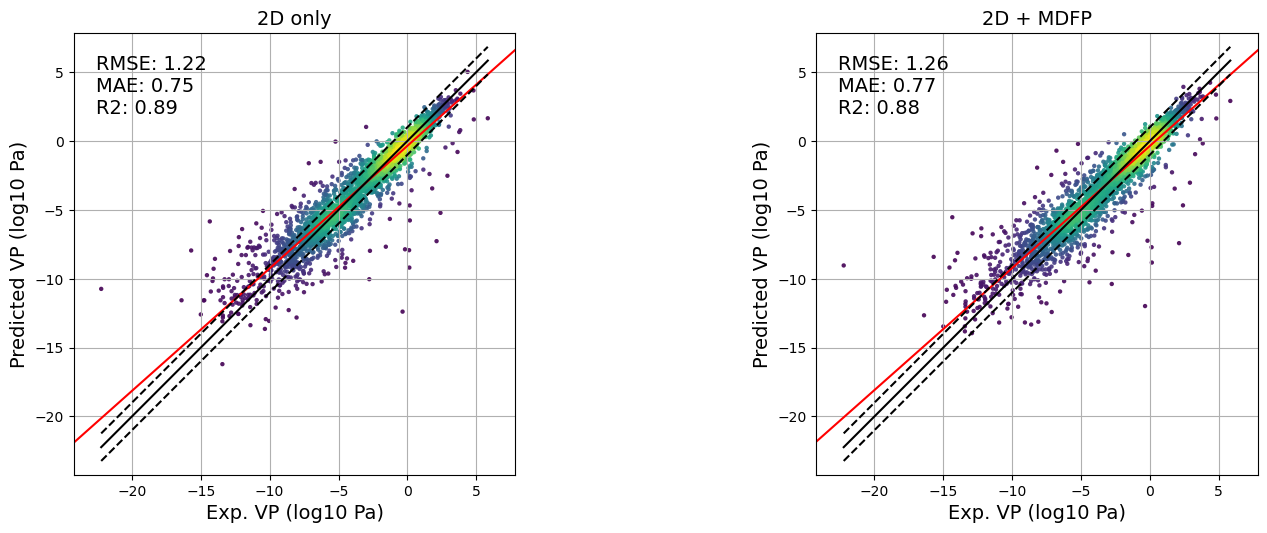

In [22]:
from carl.utils_carl import density_plot_multiple
density_plot_multiple(reals = [real_2d_only,real_combined],predictions=[prediction_2d_only,prediction_combined],titles = ['2D only','2D + MDFP'])